In [1]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

import monai
from monai import transforms

In [2]:
def adjust_window(image, window_level=35, window_width=85):
    # 计算窗宽和窗位的最小和最大值
    min_value = window_level - window_width // 2
    max_value = window_level + window_width // 2

    # 将图像裁剪到指定的窗宽范围内
    windowed_image = np.clip(image, min_value, max_value)

    # 归一化图像到0-255范围
    windowed_image = ((windowed_image - min_value) / (max_value - min_value) * 255).astype(np.uint8)

    return windowed_image

In [14]:
def visualize(original_data, aug_data=None, ori_idx=20, aug_idx=20):
    original_image = original_data["image"]
    original_mask = original_data["label"]
    if len(original_image.shape) == 4:
        original_image = original_image[0]
    if len(original_mask.shape) == 4:
        original_mask = original_mask[0]
    original_image = original_image.numpy()
    original_image = adjust_window(original_image)
    original_mask = original_mask.numpy()
    original_image = original_image[:, :, ori_idx]
    original_mask = original_mask[:, :, ori_idx]
    if aug_data is not None:
        image = aug_data["image"]
        mask = aug_data["label"]
        if len(image.shape) == 4:
            image = image[0]
        if len(mask.shape) == 4:
            mask = mask[0]
        image = image.numpy()
        image = adjust_window(image)
        image = image[:, :, aug_idx]
        mask = mask.numpy()
        mask = mask[:, :, aug_idx]
        
    
    fontsize = 12

    if aug_data is None:
        f, ax = plt.subplots(1, 2, figsize=(8, 8))

        ax[0].imshow(original_image, cmap='gray')
        ax[1].imshow(original_mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image, cmap='gray')
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image, cmap='gray')
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [4]:
def print_info(data):
    print(f"image shape: {data['image'].shape}, image type: {type(data['image'])}")
    print(f"label shape: {data['label'].shape}, label type: {type(data['label'])}")

In [5]:
data_dict = {
    'image': '../data/ID_c9d6fdc6_ID_7f09be285d.nii.gz',
    'label': '../data/ID_c9d6fdc6_ID_7f09be285d-ich_seg.nii.gz'
}

In [6]:
# 数据读取
io_transform = transforms.LoadImaged(keys=["image", "label"])
data = io_transform(data_dict)
image, label = data['image'], data['label']
print(f"image shape: {image.shape}, image type: {type(image)}")
print(f"label shape: {label.shape}, label type: {type(label)}")

image shape: torch.Size([512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


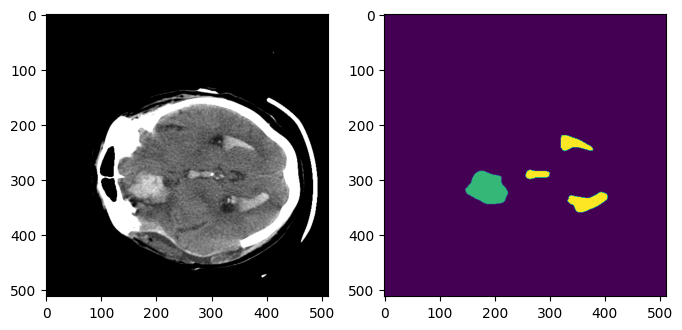

In [7]:
visualize(data)

In [8]:
# 添加channel维度
transform = transforms.EnsureChannelFirstd(keys=["image", "label"])
add_data = transform(data)
print_info(add_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


In [11]:
# 数据保存
transform = transforms.SaveImaged(keys=["image", "label"], output_dir="output", output_ext=".nii.gz", separate_folder=False)
aug_data = transform(data)
print_info(aug_data)

2025-05-15 19:46:15,453 INFO image_writer.py:197 - writing: output\ID_c9d6fdc6_ID_7f09be285d_trans.nii.gz
2025-05-15 19:46:16,273 INFO image_writer.py:197 - writing: output\ID_c9d6fdc6_ID_7f09be285d-ich_pred_trans.nii.gz
image shape: torch.Size([512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


In [51]:
# 将数据pad至指定spatial_size
# - 输入为3D数据，需增强channel维度，即输入[C, H, W, D], spatial_size = [h, w, d]
# - 输入为2D数据，即输入[C, H, W], spatial_size = [h, w]
transform = transforms.SpatialPadd(keys=["image", "label"], spatial_size=[768, 768, 38])

aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 768, 768, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 768, 768, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


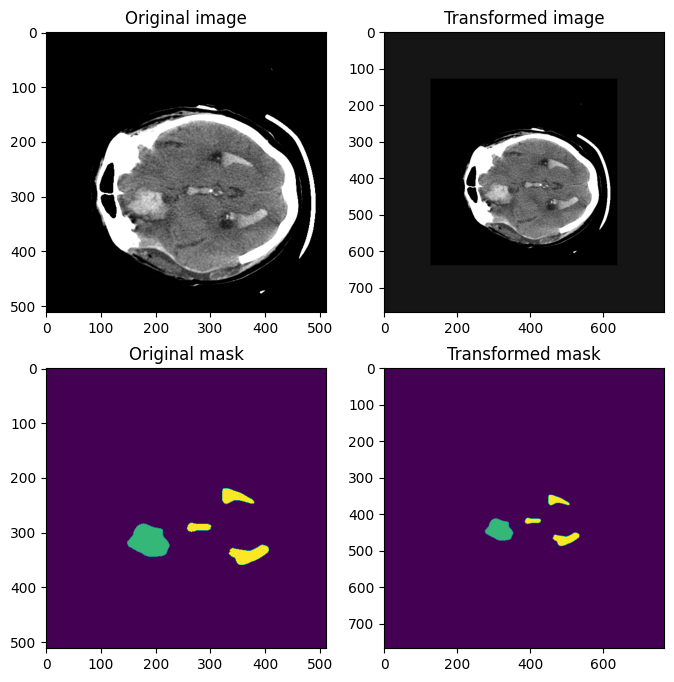

In [49]:
visualize(data, aug_data)

In [52]:
transform = transforms.BorderPadd(keys=["image", "label"], spatial_border=[32, 32, 0])
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 576, 576, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 576, 576, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


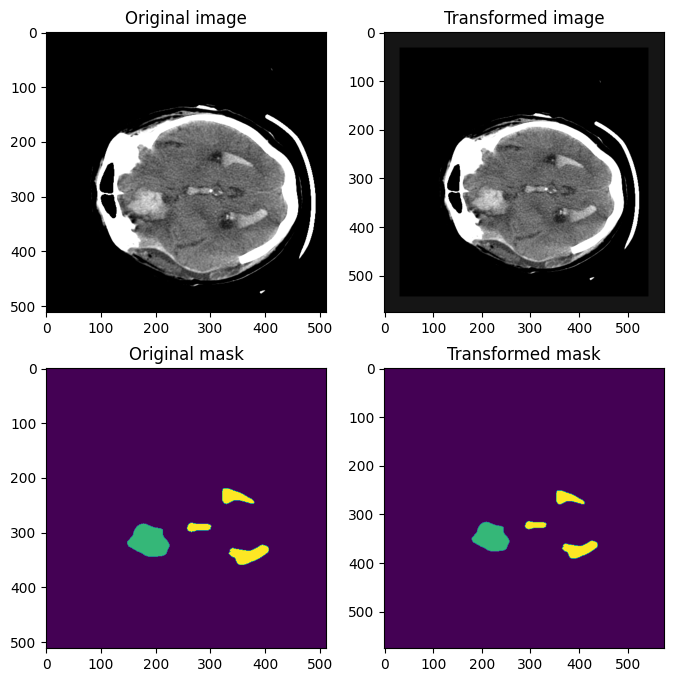

In [53]:
visualize(data, aug_data)

In [54]:
transform = transforms.DivisiblePadd(keys=["image", "label"], k=32)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 512, 512, 64]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 64]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


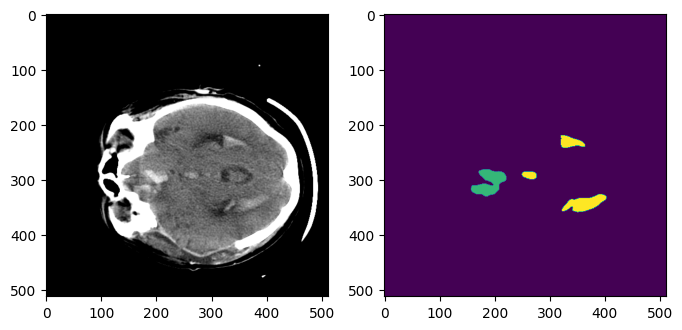

In [55]:
visualize(data, idx=19)

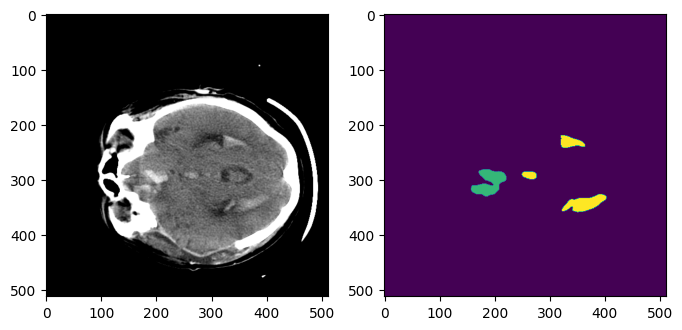

In [56]:
visualize(aug_data, idx=32)

In [62]:
transform = transforms.SpatialCropd(
    keys=["image", "label"],
    roi_center=[256, 256, 19],
    roi_size=[384, 384, 38]
)

transform = transforms.SpatialCropd(
    keys=["image", "label"],
    roi_start=[32, 32, 0],
    roi_end=[484, 484, 38]
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 452, 452, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 452, 452, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


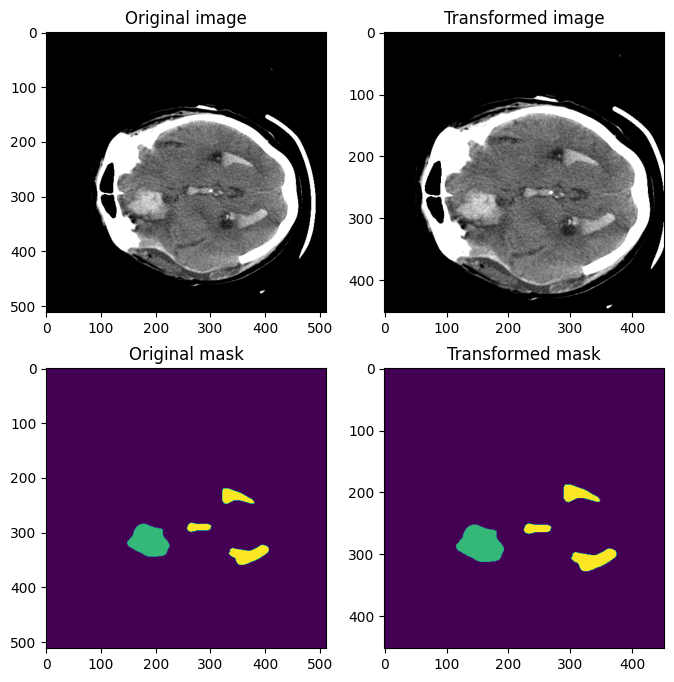

In [63]:
visualize(data, aug_data)

In [66]:
transform = transforms.CenterSpatialCropd(
    keys=["image", "label"],
    roi_size=[384, 384, 38]
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 384, 384, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 384, 384, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


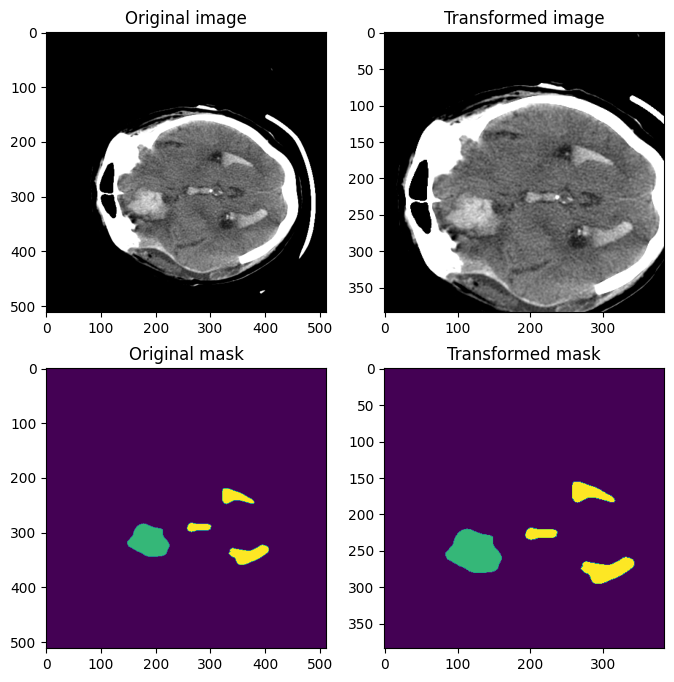

In [67]:
visualize(data, aug_data)

In [68]:
transform = transforms.CenterScaleCropd(
    keys=["image", "label"],
    roi_scale=[0.6, 0.6, 1]
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 308, 308, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 308, 308, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


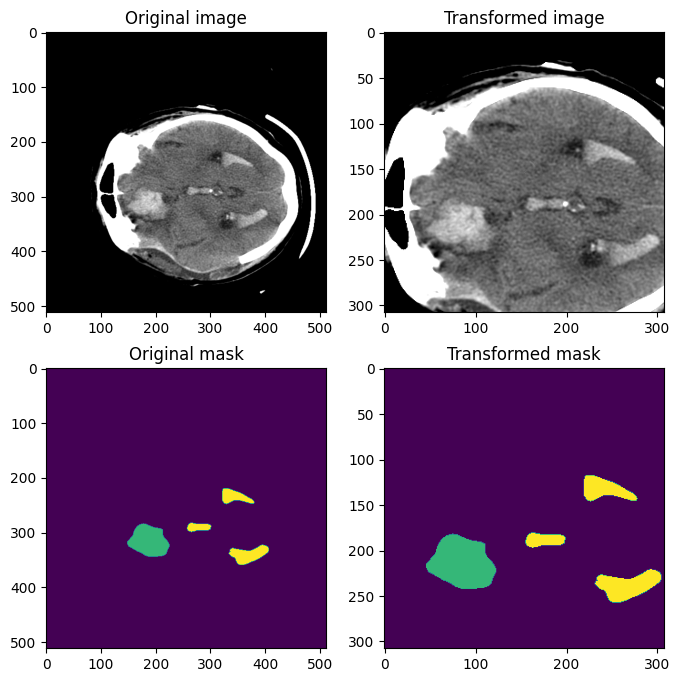

In [69]:
visualize(data, aug_data)

In [71]:
transform = transforms.RandSpatialCropd(
    keys=["image", "label"],
    roi_size=[224, 224, 38],
    max_roi_size=[512, 512, 38],
    random_size=True
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 406, 356, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 406, 356, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


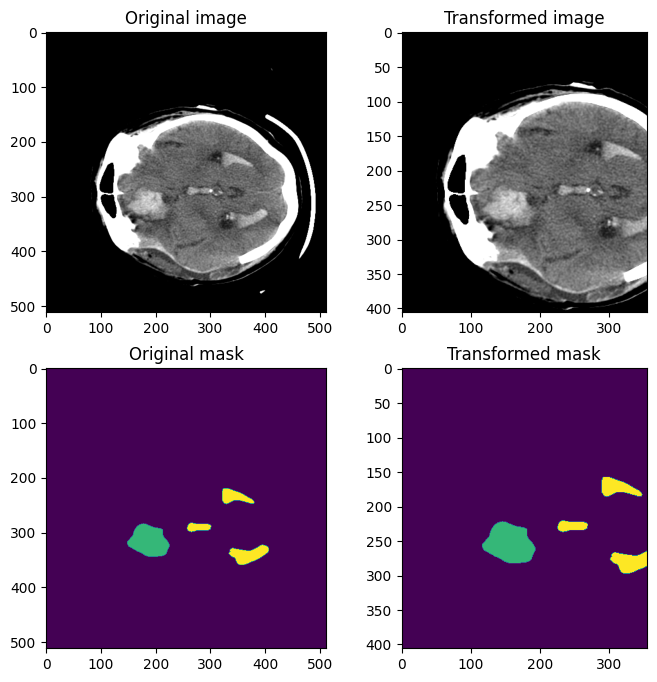

In [72]:
visualize(data, aug_data)

In [76]:
transform = transforms.RandScaleCropd(
    keys=["image", "label"],
    roi_scale=[0.3, 0.3, 1],
    max_roi_scale=[1, 1, 1],
    random_size=True
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 331, 424, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 331, 424, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


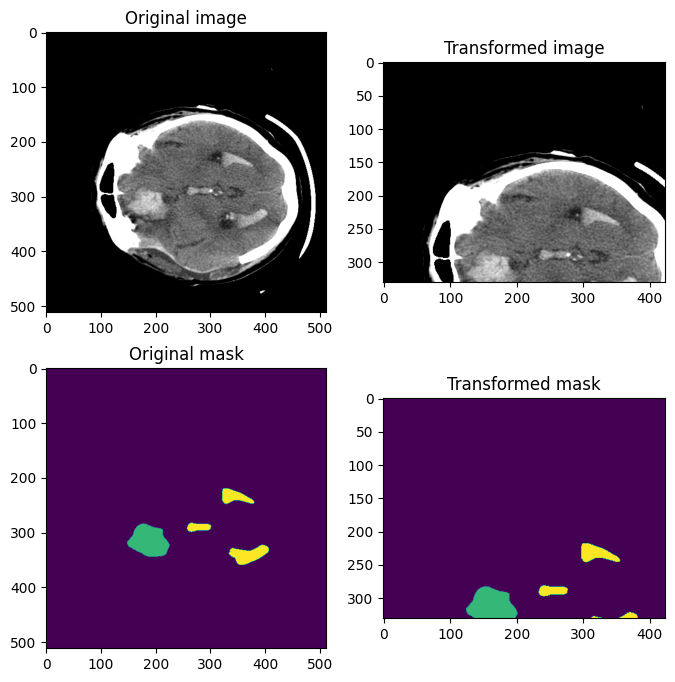

In [77]:
visualize(data, aug_data)

In [78]:
transform = transforms.RandSpatialCropSamplesd(
    keys=["image", "label"],
    roi_size=[224, 224, 38],
    max_roi_size=[512, 512, 38],
    num_samples=4,
    random_size=True
)
aug_datas = transform(add_data)
len(aug_datas)

4

In [80]:
print_info(aug_datas[0])

image shape: torch.Size([1, 266, 439, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 266, 439, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


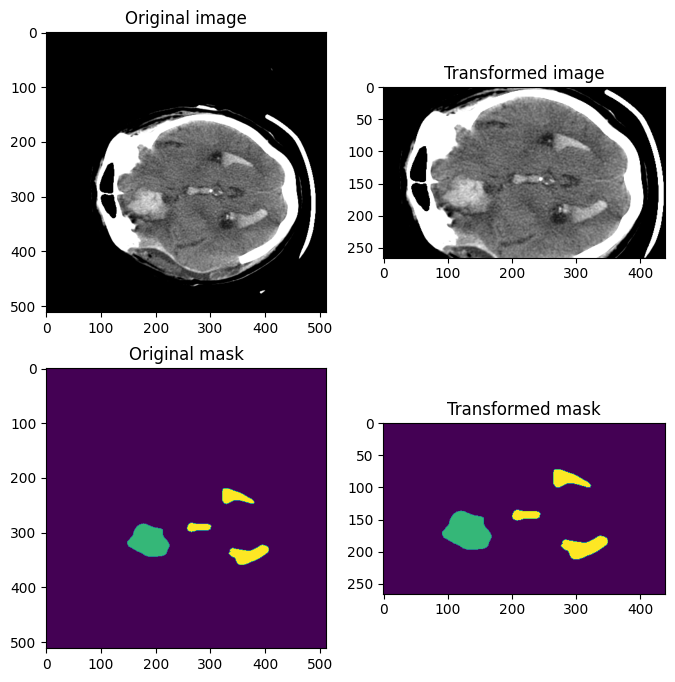

In [81]:
visualize(data, aug_datas[0])

In [92]:
transform = transforms.CropForegroundd(
    keys=["image", "label"],
    source_key="image"
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 418, 456, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 418, 456, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


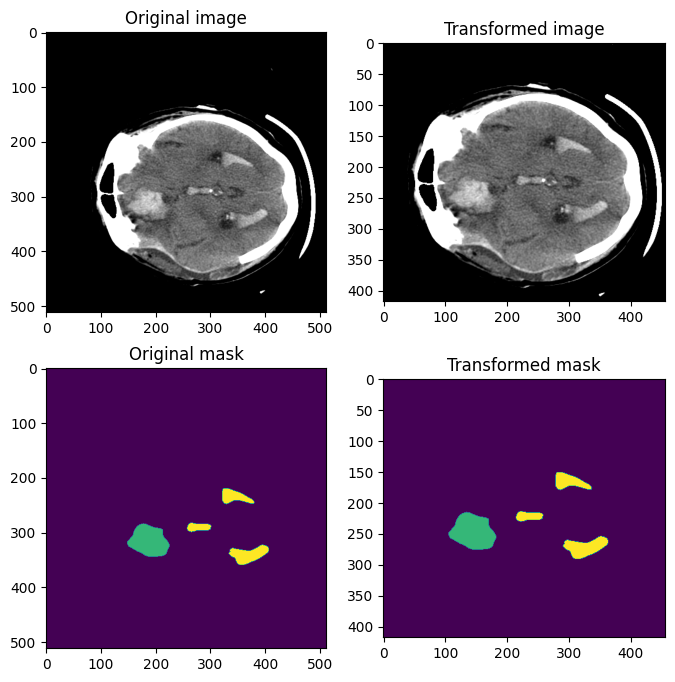

In [89]:
visualize(data, aug_data)

In [116]:
transform = transforms.RandCropByPosNegLabeld(
    keys=["image", "label"],
    label_key="label",
    spatial_size=[224, 224, 38],
    pos=5,
    neg=1,
    num_samples=2,
    image_key="image",
    image_threshold=0
)
aug_datas = transform(add_data)
len(aug_datas)

2

image shape: torch.Size([1, 224, 224, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 224, 224, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


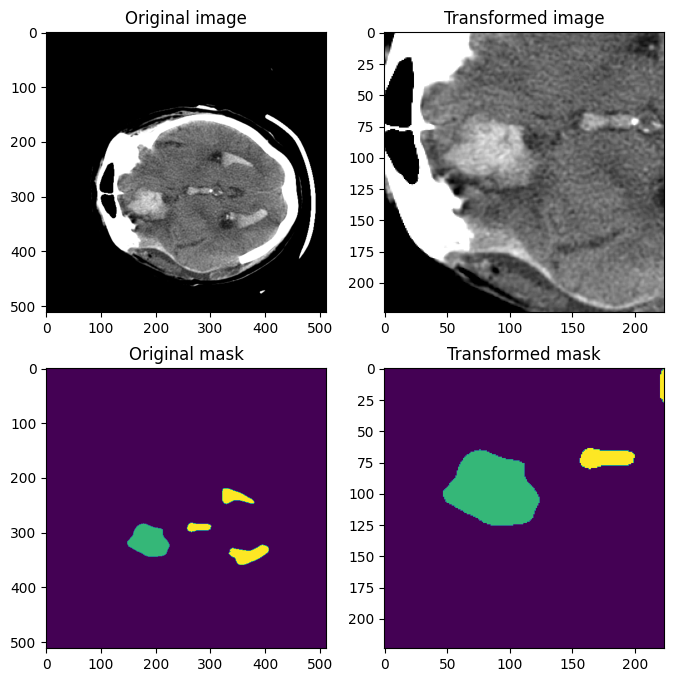

In [117]:
print_info(aug_datas[0])
visualize(data, aug_datas[0])

image shape: torch.Size([1, 224, 224, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 224, 224, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


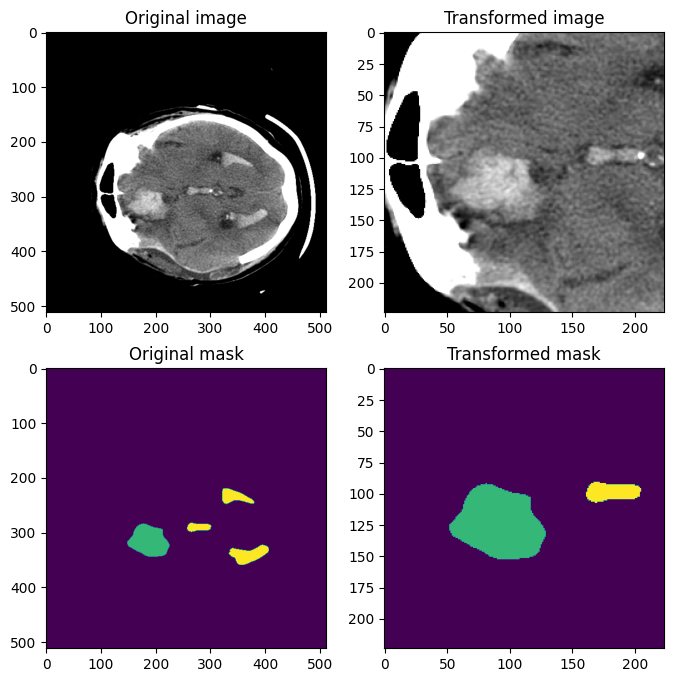

In [118]:
print_info(aug_datas[1])
visualize(data, aug_datas[1])

image shape: torch.Size([1, 448, 448, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 448, 448, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


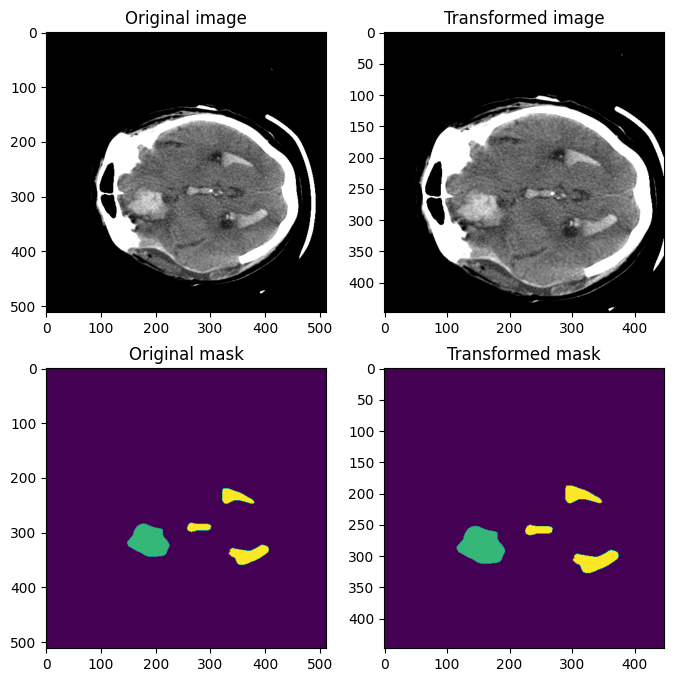

In [121]:
transform = transforms.ResizeWithPadOrCropd(
    keys=["image", "label"],
    spatial_size=[448, 448, 38]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

image shape: torch.Size([1, 768, 768, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 768, 768, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


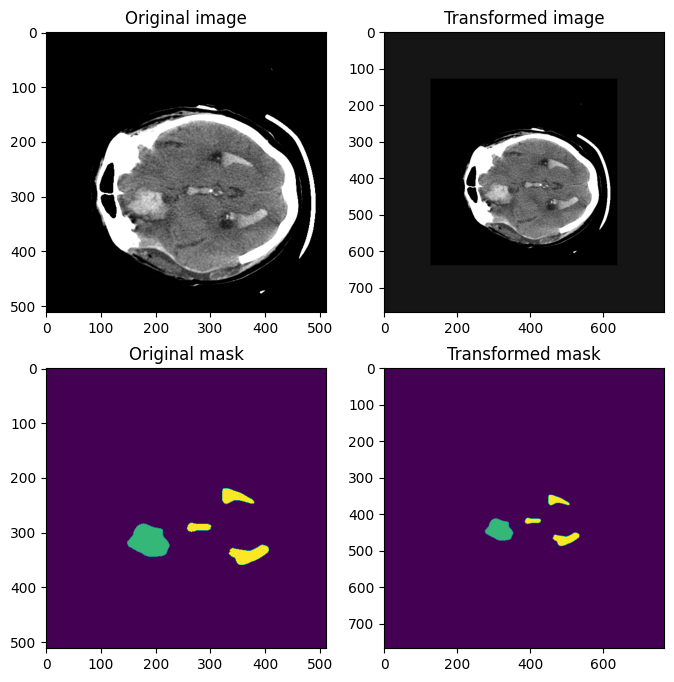

In [122]:
transform = transforms.ResizeWithPadOrCropd(
    keys=["image", "label"],
    spatial_size=[768, 768, 38]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

在高斯噪声（Gaussian noise）的生成中，`mean` 和 `std`（标准差）起着关键作用。

1. **mean（均值）**：它控制噪声的中心位置，也就是说噪声的期望值。通常，均值设置为0，这样生成的噪声在统计上就不会偏离原始信号。如果均值不为0，噪声会偏向某个方向，可能导致信号失真。

2. **std（标准差）**：它控制噪声的分布范围或强度。标准差越大，噪声的波动范围越广，噪声的影响就越强；标准差越小，噪声更集中，影响较小。通过调整标准差，可以控制噪声的强度，进而控制信号的失真程度。

总结来说，`mean` 决定噪声的偏移位置，`std` 决定噪声的强度。根据具体应用的需求，可以调整这两个参数来实现不同类型的噪声干扰效果。

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


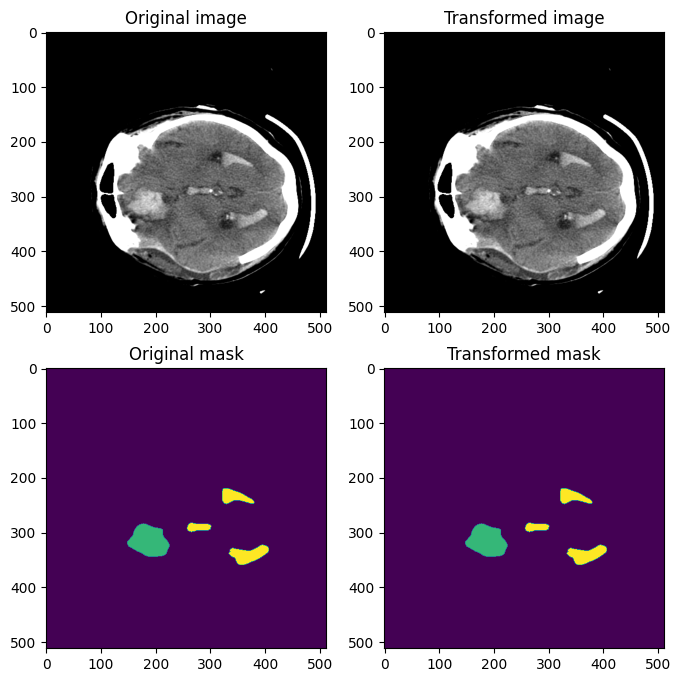

In [148]:
transform = transforms.RandGaussianNoised(
    keys=["image"],
    prob=1,
    mean=0,
    std=1
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

在信号处理和图像处理领域，RandRicianNoise（瑞利噪声）是一种常见的噪声类型，用于模拟信号中的随机噪声。这种噪声的特点是噪声值服从瑞利分布。瑞利噪声广泛应用于无线通信、医学影像（如MRI）和其他需要模拟噪声的领域。

在生成瑞利噪声时，通常会使用两个参数来描述噪声的统计特性：

1. **mean（均值）**：这是噪声的期望值，表示噪声的平均水平。在瑞利噪声中，均值通常指的是噪声信号的幅度的平均值。
   
2. **std（标准差）**：这是衡量噪声波动程度的指标，表示噪声的分散程度。标准差越大，噪声的变化越剧烈，影响信号的程度也就越大。

具体来说，均值和标准差的作用如下：

- **均值**：影响瑞利噪声的幅度。如果均值增大，噪声的幅度会变大，信号的强度也会增加。
  
- **标准差**：控制噪声的强度和变化范围。标准差越大，噪声的变化越显著，导致更强的干扰。

在实际应用中，调整这些参数可以帮助模拟不同的噪声环境，从而更好地测试和优化信号处理算法或设备性能。

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


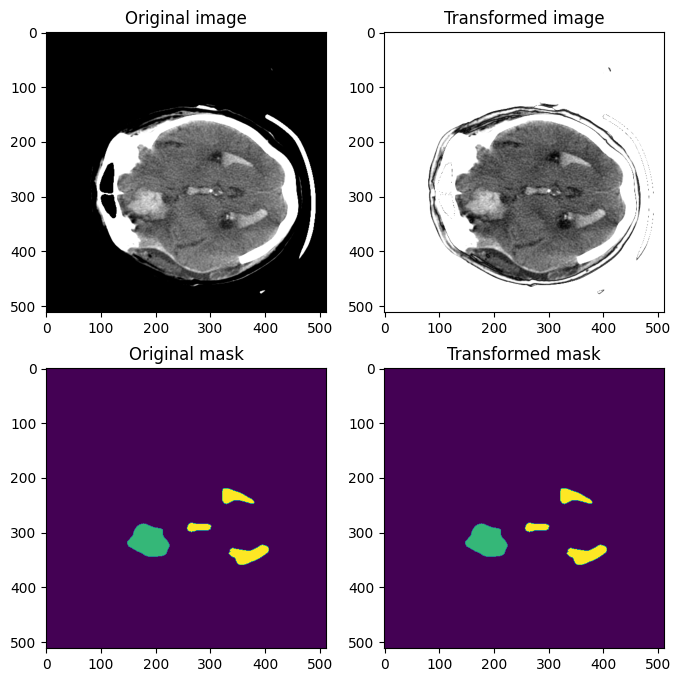

In [151]:
transform = transforms.RandRicianNoised(
    keys=["image"],
    prob=1,
    mean=0,
    std=1
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

图像处理中，**Shift Intensity（强度偏移）** 是一种简单的图像操作，通常用于调整图像像素的亮度或对比度。它的基本原理是对图像中的每个像素值进行一个常数的加减运算，从而改变图像的整体亮度。

### Shift Intensity 的工作原理：
1. **像素值调整**：在图像处理过程中，每个像素的颜色通常由RGB（红绿蓝）值组成，或者由灰度值（单通道）表示。通过对每个像素的值进行加上或减去一个常数（称为“偏移量”），可以使得整个图像变得更亮或更暗。
   
2. **数学表达式**：
   - 对于灰度图像，设定每个像素的灰度值为 \( I(x, y) \)，偏移量为 \( \Delta \)，则调整后的像素值为：
     \[
     I'(x, y) = I(x, y) + \Delta
     \]
     其中 \( \Delta \) 是常数，正值会使图像变亮，负值则会使图像变暗。

   - 对于彩色图像，RGB 每个通道都可以单独进行强度偏移。例如：
     \[
     R'(x, y) = R(x, y) + \Delta_R
     \]
     \[
     G'(x, y) = G(x, y) + \Delta_G
     \]
     \[
     B'(x, y) = B(x, y) + \Delta_B
     \]
     其中，\( \Delta_R, \Delta_G, \Delta_B \) 分别是红、绿、蓝通道的偏移量。

### 应用：
1. **图像亮度调整**：通过增加一个常数，所有像素的亮度都会增加，通常用来使图像更明亮。
   
2. **图像对比度调整**：虽然 Shift Intensity 主要影响亮度，但它有时也被用来简化对比度的调整，特别是在一些基础的图像处理任务中。

3. **增强或抑制细节**：对图像的某些区域进行强度偏移，可以突出或抑制某些特征，尤其在医学影像或卫星图像处理中经常使用。

### 注意事项：
- **像素值限制**：图像的每个像素值通常有范围限制（例如 0 到 255 对于 8 位图像），因此在进行偏移时，需要确保不会超过这个范围。如果偏移导致像素值超过上限或低于下限，需要进行裁剪（clipping），即将超出范围的像素值设置为最大值或最小值。
  
- **色彩失真**：在彩色图像中，如果偏移量设置不当，可能会导致色彩失真，尤其是在 RGB 分量之间的平衡被打破时。

总结来说，Shift Intensity 是一个简单但有效的图像调整技术，广泛用于图像增强和预处理。

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


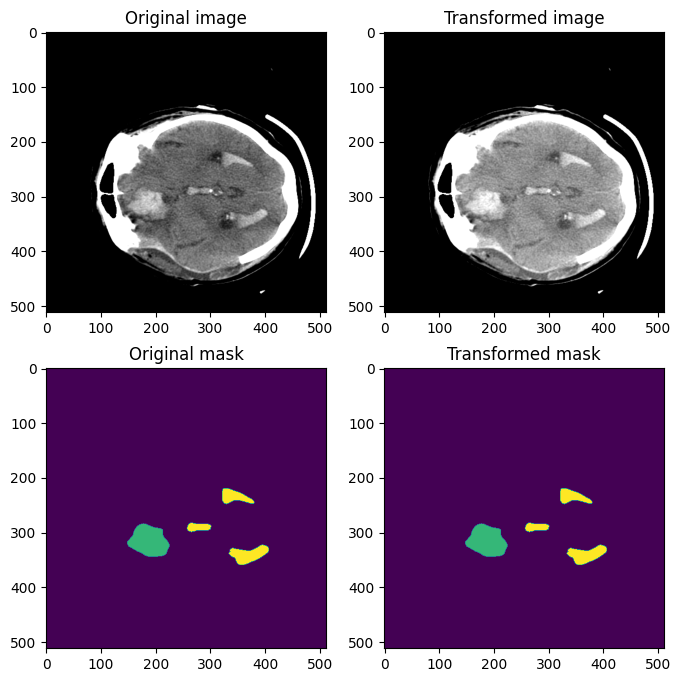

In [180]:
 transform = transforms.RandShiftIntensityd(
     keys=["image"],
     offsets=[10, 20],
     prob=1
 )
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

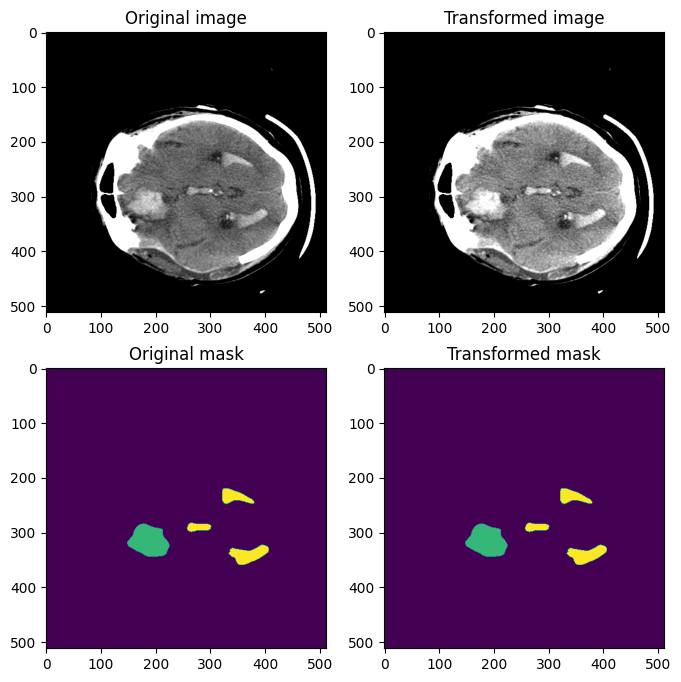

In [19]:
# v = v * (1 + factor)
transform = transforms.RandScaleIntensityd(
    keys="image", 
    factors=(0.3, 0.5), 
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

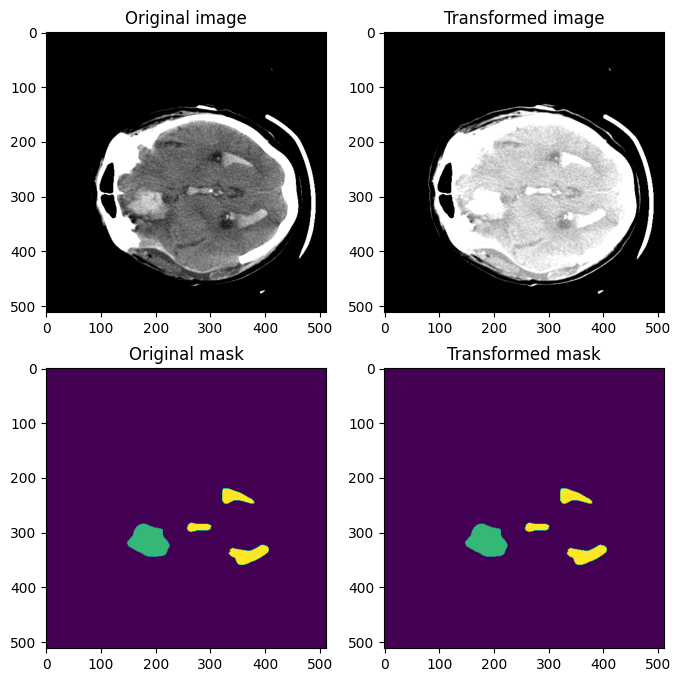

In [22]:
# v = v - mean(v)
# v = v * (1 + factor) + mean(v)
transform = transforms.RandScaleIntensityFixedMeand(
    keys="image",
    factors=0.2,
    fixed_mean=True,
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

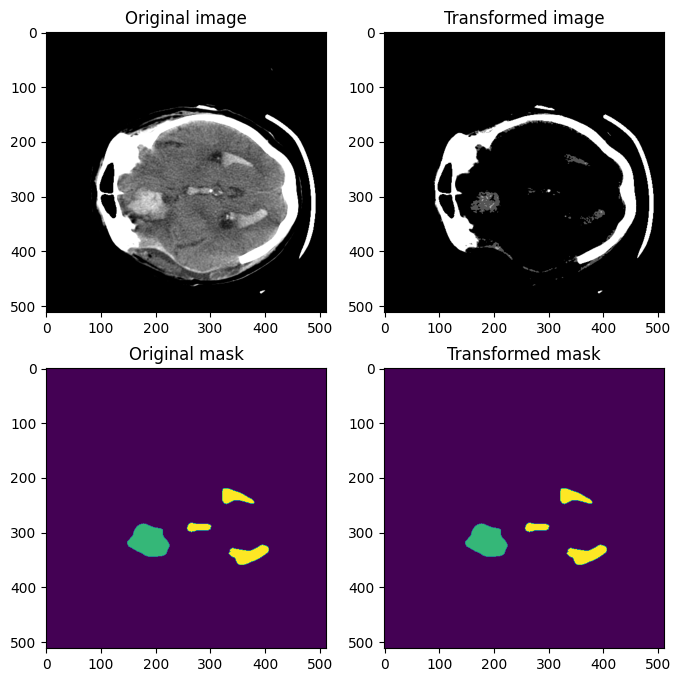

In [34]:
# img = (img - a_min) / (a_max - a_min)
# img = img * (b_max - b_min) + b_min
# if clip img = clip(img, b_min, b_max)
transform = transforms.ScaleIntensityRanged(
    keys="image",
    a_min=40,
    a_max=80,
    b_min=0,
    b_max=1,
    clip=True
)
aug_data = transform(add_data)
visualize(data, aug_data)

## 📌 Bias Field 数据增强的原理 

1. **偏置场的定义** 

Bias Field 是一种低频的乘性场，表示为：

$$
 I_{\text{observed}}(x) = I_{\text{true}}(x) \cdot B(x) 
$$


其中：

 
- $I_{\text{observed}}(x)$ 是观测到的图像；
 
- $I_{\text{true}}(x)$ 是理想（无偏）的图像；
 
- $B(x)$ 是偏置场，通常是一个缓慢变化的乘性系数。

2. **生成偏置场的方法** 
在数据增强中，我们人工生成一个模拟的偏置场 $B(x)$，再乘到原图像上，形成增强后的图像。

生成偏置场通常的方法包括：


#### ✅ 多项式建模（常用方法） 


使用低阶多项式或贝塞尔函数在图像空间中生成平滑变化的场。例如：



```python
B(x, y, z) = a0 + a1*x + a2*y + a3*z + a4*x*y + a5*x*z + ...
```

系数 $a_i$ 是从一个预设范围内随机采样的，以保证多样性和随机性。



3. **增强效果** 
 
- **模拟真实世界MRI设备中的伪影** ；
 
- **提高模型的鲁棒性** ，使其对强度变化不敏感；
 
- **避免模型过拟合到某个扫描设备的图像特性** 。


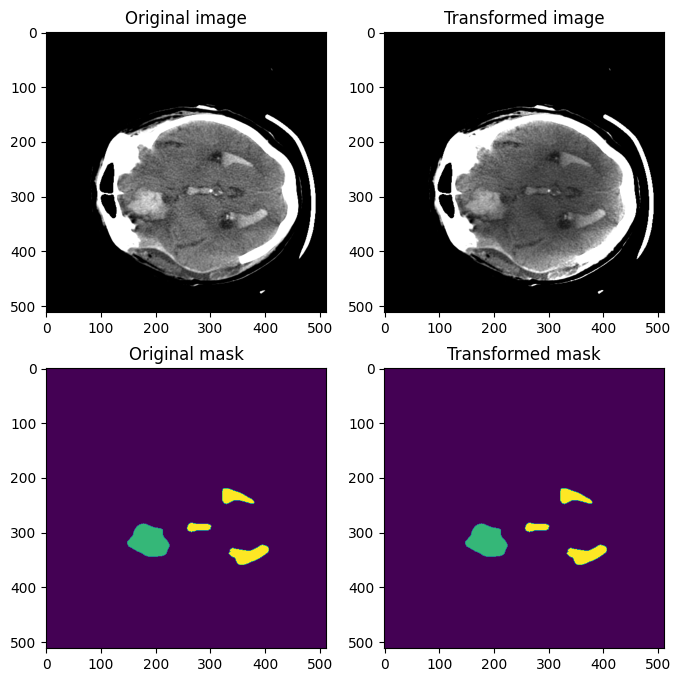

In [32]:
transform = transforms.RandBiasFieldd(
    keys="image",
    degree=3,
    coeff_range=(0.7, 1),
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

image mean: 0.0, image std: 1.0


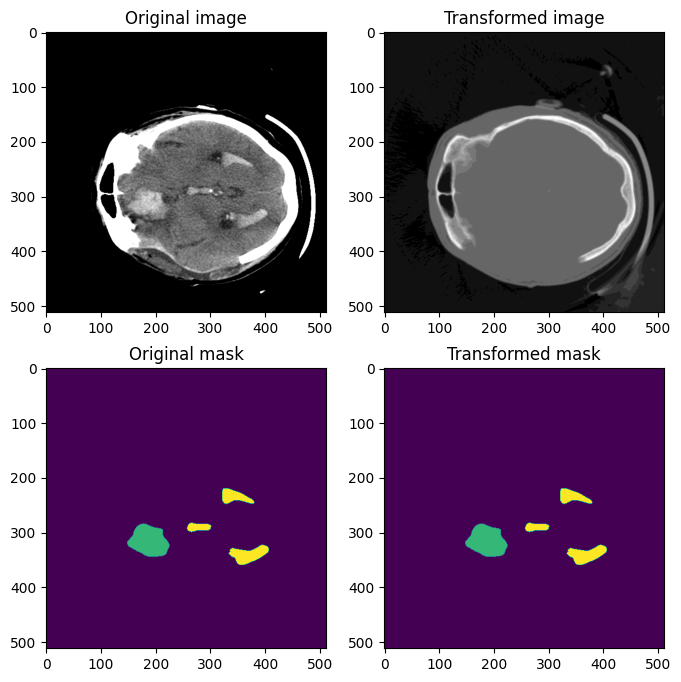

In [37]:
transform = transforms.NormalizeIntensityd(
    keys="image"
)
aug_data = transform(add_data)
print(f"image mean: {aug_data['image'].mean()}, image std: {aug_data['image'].std()}")
visualize(data, aug_data)

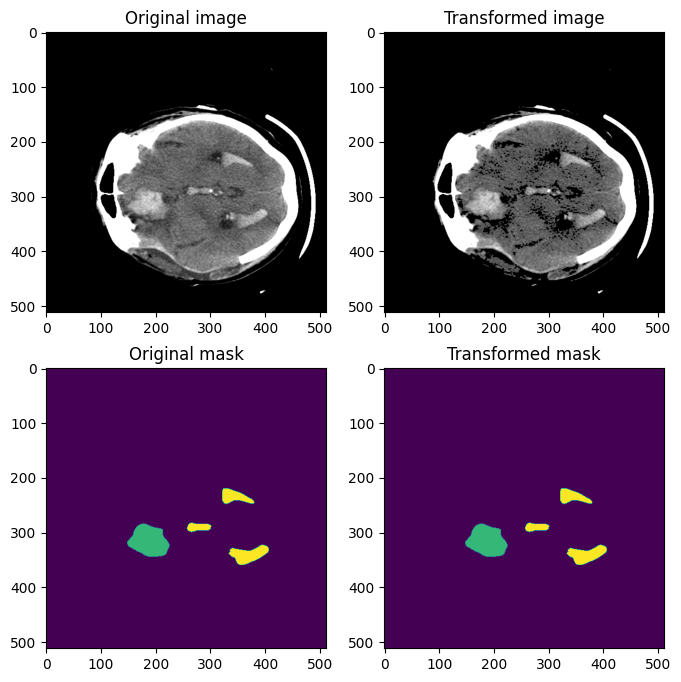

In [51]:
transform = transforms.ThresholdIntensityd(
    keys="image",
    threshold=20,
    cval=0
)
aug_data = transform(add_data)
visualize(data, aug_data)

intensity range: 63859.0


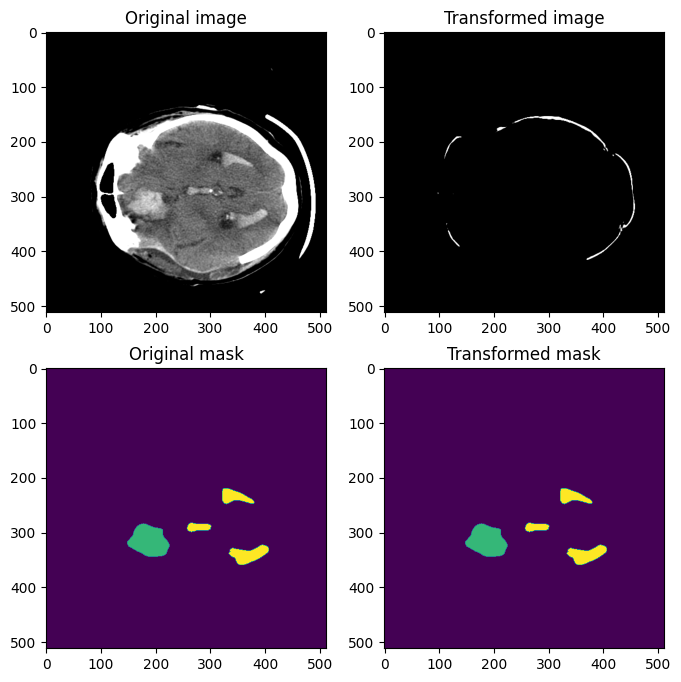

In [75]:
# x = ((x - min) / intensity_range) ^ gamma * intensity_range + min
transform = transforms.RandAdjustContrastd(
    keys="image",
    prob=1,
    gamma=(0.99, 1.1)
)
aug_data = transform(add_data)
print(f"intensity range: {data['image'].max() - data['image'].min()}")
visualize(data, aug_data)

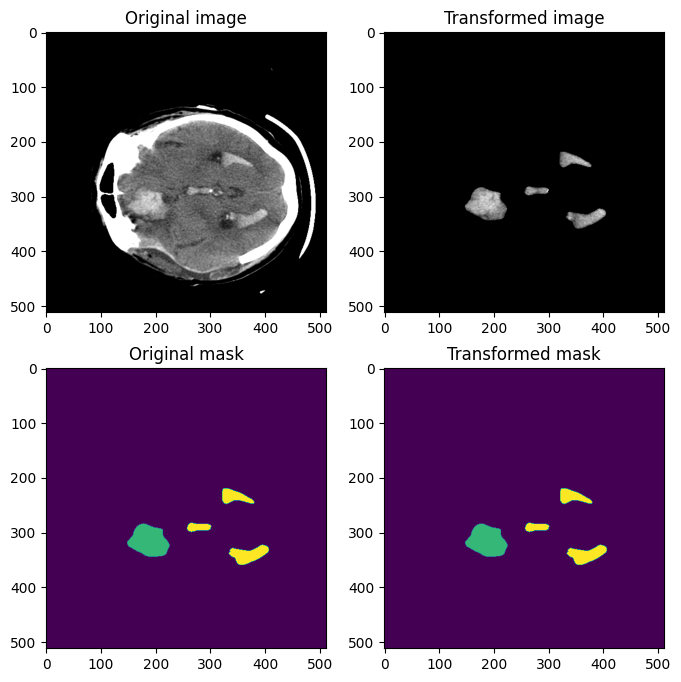

In [79]:
# extract the mask data/key from input data
transform = transforms.MaskIntensityd(
    keys="image",
    # mask_data=add_data["image"] - 20
    mask_key="label"
)
aug_data = transform(add_data)
visualize(data, aug_data)

Savitzky-Golay 平滑（Savitzky-Golay smoothing）是一种常用于**信号处理和数据平滑** 的滤波方法，旨在在 **保持信号特征（如峰值、宽度、斜率）** 的同时，减少噪声。它比简单的移动平均更能保留信号的局部结构。


---



## 🧠 原理概述 


Savitzky-Golay 平滑的核心思想是：


> **在滑动窗口内拟合多项式，并用该多项式的值替换中心点的值** 。



---



## 📐 数学原理 

1. **滑动窗口** 
设有一个信号序列 $y = [y_1, y_2, ..., y_n]$，选定一个窗口宽度 $2k+1$（奇数），在每个位置 $i$，取该点为中心的一段数据：
$$
 [y_{i-k}, ..., y_i, ..., y_{i+k}] 
$$

2. **多项式拟合** 
在这个局部窗口中，对这些点拟合一个**固定阶数（如2阶或3阶）的多项式** ：
$$
 f(x) = a_0 + a_1 x + a_2 x^2 + \dots + a_d x^d 
$$

 
- $d$：多项式阶数（通常 < 窗口宽度）
 
- $x$：以当前中心为原点，局部变量 $-k \leq x \leq k$

通过**最小二乘法** 拟合这个多项式。
3. **替换中心点** 
使用这个拟合多项式在 $x=0$（即窗口中心）的位置的值替代原始信号的当前值。


---



## ✅ 优势 

 
- **保留边缘/峰值特征** ：不像移动平均那样模糊尖锐变化。
 
- **支持导数估计** ：拟合的多项式可用于求导，常用于一阶/二阶导数估计。
 
- **适用于光谱数据、实验信号等** 。



---



## 📊 参数总结 

| 参数 | 含义 | 
| --- | --- | 
| window_length | 滑动窗口的宽度（必须是奇数） | 
| polyorder | 多项式拟合的阶数（小于 window_length） | 



---




## 📎 应用场景 

 
- 光谱分析（IR、NMR、Raman）
 
- 信号平滑（如脑电、心电）
 
- 实验数据降噪
 
- 实时传感器数据处理

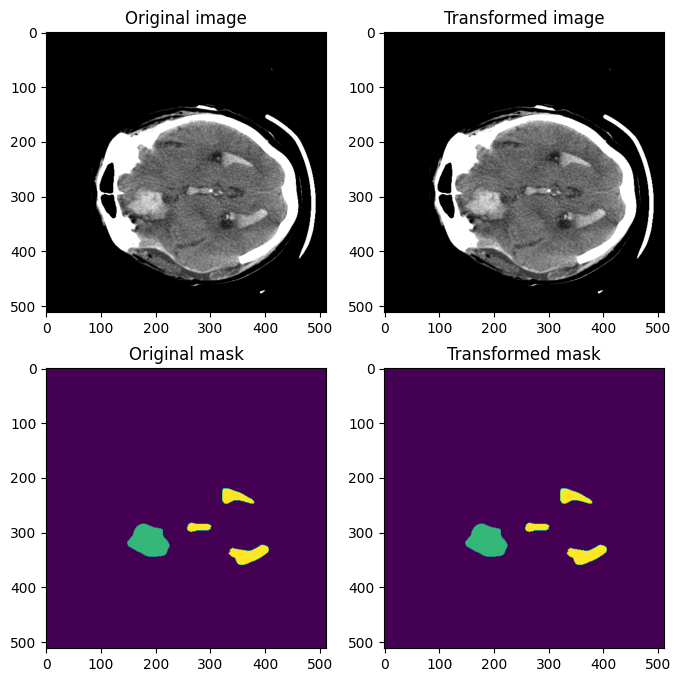

In [82]:
transform = transforms.SavitzkyGolaySmoothd(
    keys="image",
    window_length=7,
    order=4
)
aug_data = transform(add_data)
visualize(data, aug_data)

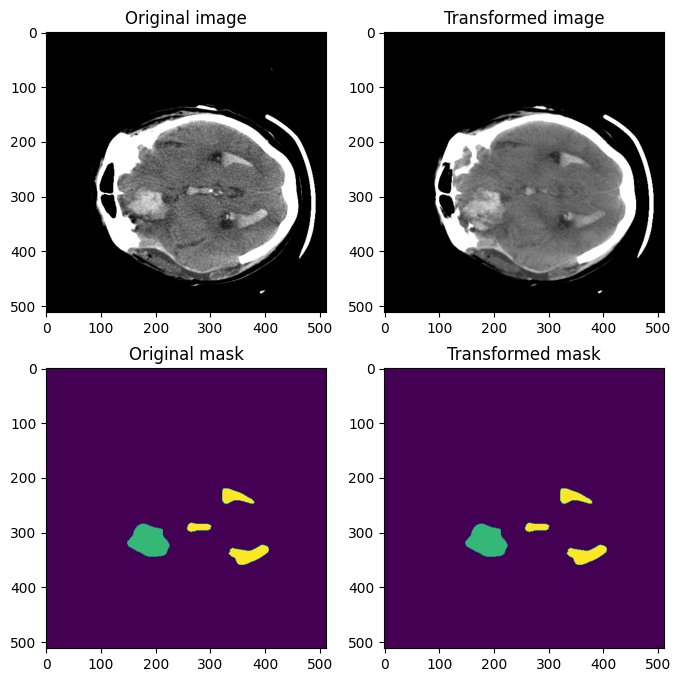

In [85]:
transform = transforms.MedianSmoothd(
    keys="image",
    radius=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

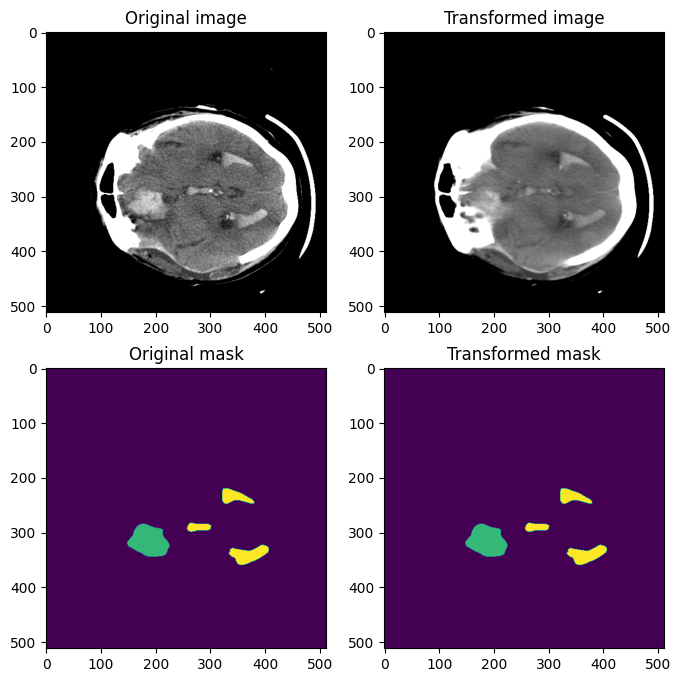

In [93]:
transform = transforms.RandGaussianSmoothd(
    keys="image",
    sigma_x=(0.25, 1.25),
    sigma_y=(0.25, 1.25),
    sigma_z=(0.25, 1.25),
    prob=1,
    approx="erf"   # erf sampled scalespace
)
aug_data = transform(add_data)
visualize(data, aug_data)

GaussianSharpen 是一种基于高斯滤波的图像锐化方法，其基本原理是通过对图像进行高斯模糊处理，然后将模糊图像与原始图像结合，增强图像的边缘细节。


其核心原理可以用以下数学公式表示：

**锐化图像 = 原图 + α × (原图 - 高斯模糊图)** 

其中：

 
- **α**  是控制锐化程度的参数（通常 α > 0）
 
- **原图 - 高斯模糊图**  叫做“高频分量”或“细节图像”，它强调了图像中的边缘和细节
 
- 把这个高频信息加回原图，就会增强边缘，使图像看起来更“锐利”

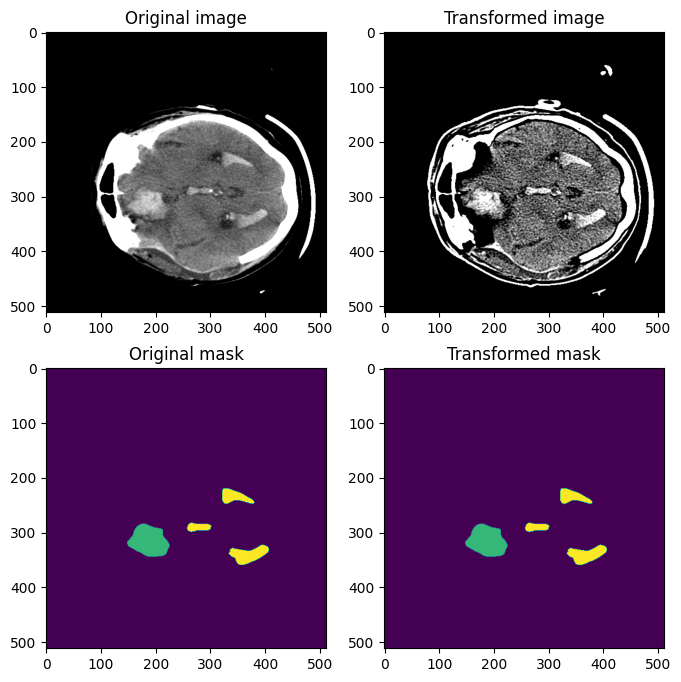

In [95]:
transform = transforms.RandGaussianSharpend(
    keys="image",
    sigma1_x=(0.25, 1.125),
    sigma1_y=(0.25, 1.25),
    sigma1_z=(0.25, 1.25),
    sigma2_x=0.2,
    sigma2_y=0.2,
    sigma2_z=0.2,
    approx="erf",
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

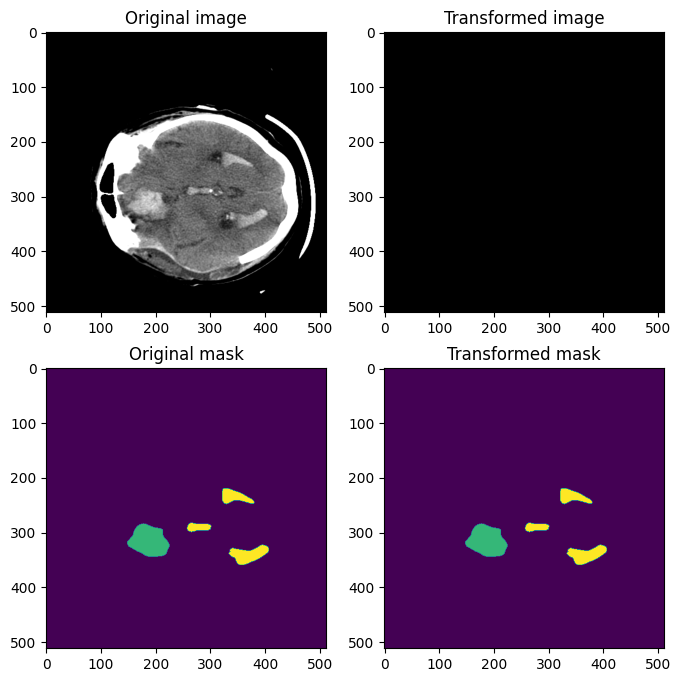

In [98]:
transform = transforms.RandHistogramShiftd(
    keys="image",
    num_control_points=5,
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

“Gibbs Noise”（吉布斯噪声）是一种在数字信号处理和图像处理中常见的伪影（artifact），主要是由于截断或有限长度的傅里叶级数（或离散余弦变换、离散傅里叶变换）所引起的。它通常出现在信号或图像中的边缘位置，以振铃或振荡的形式表现出来。

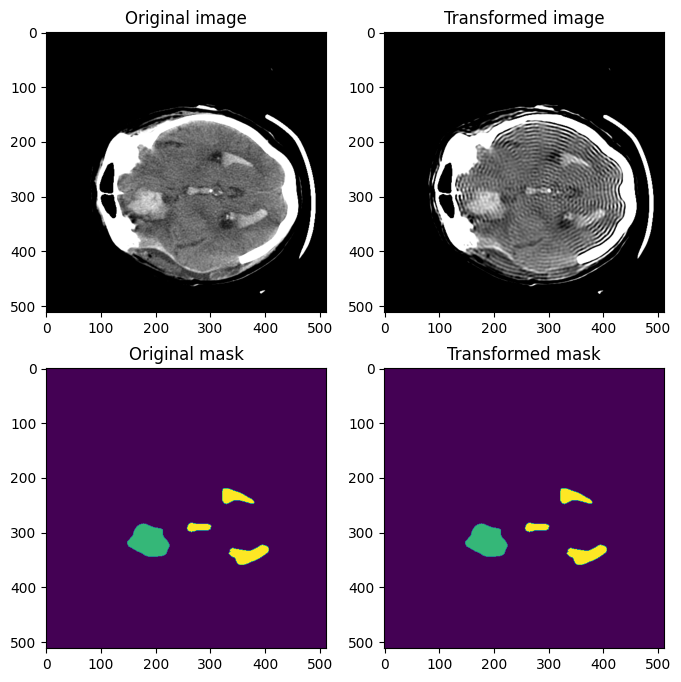

In [108]:
transform = transforms.RandGibbsNoised(
    keys="image",
    alpha=(0.4, 1),
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

K-space spike noise（K空间尖峰噪声）是一种在磁共振成像（MRI）中常见的人为噪声，主要是由于外部射频干扰或硬件故障（如接收线圈问题、电缆松动、电磁干扰等）导致的。它的本质是：在K空间（频率空间）中某些点的信号值异常地高，从而在图像空间中产生伪影。

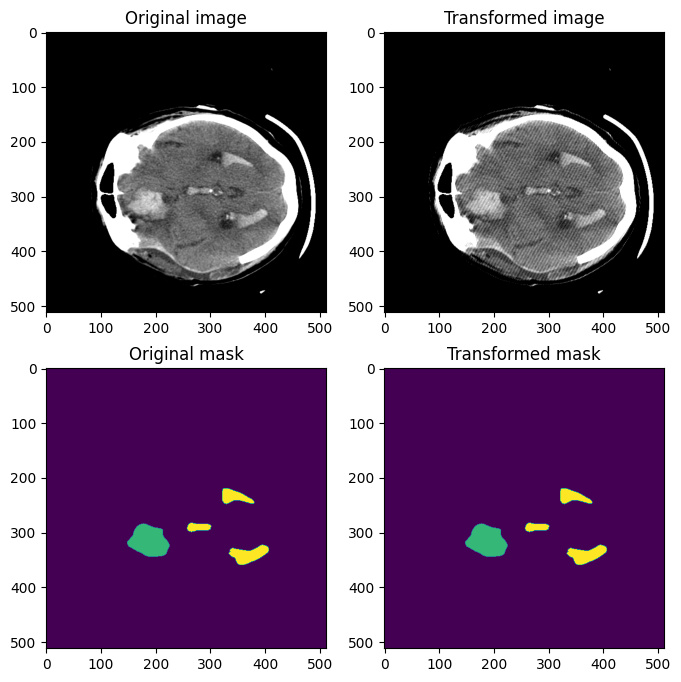

In [123]:
transform = transforms.RandKSpaceSpikeNoised(
    keys="image",
    intensity_range=(19, 20),
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

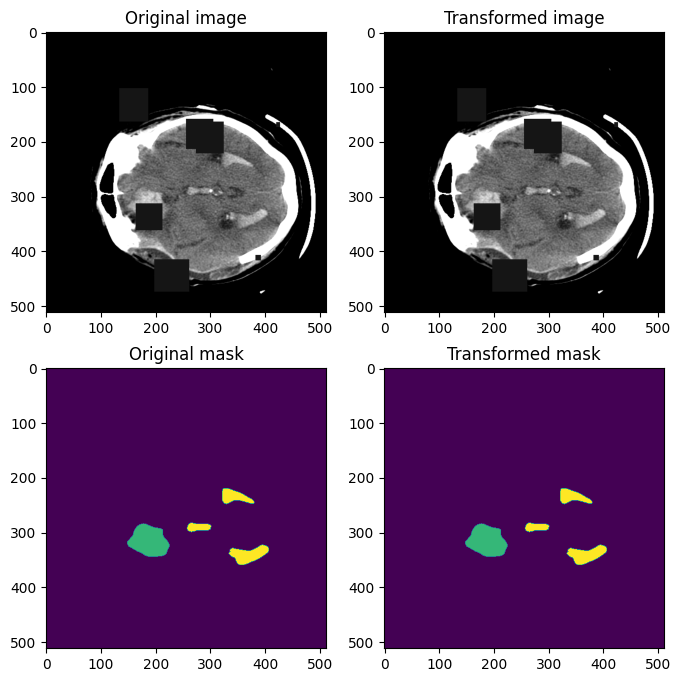

In [126]:
transform = transforms.RandCoarseDropoutd(
    keys="image",
    holes=2,
    spatial_size=38,
    fill_value=0,
    max_holes=5,
    max_spatial_size=64,
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

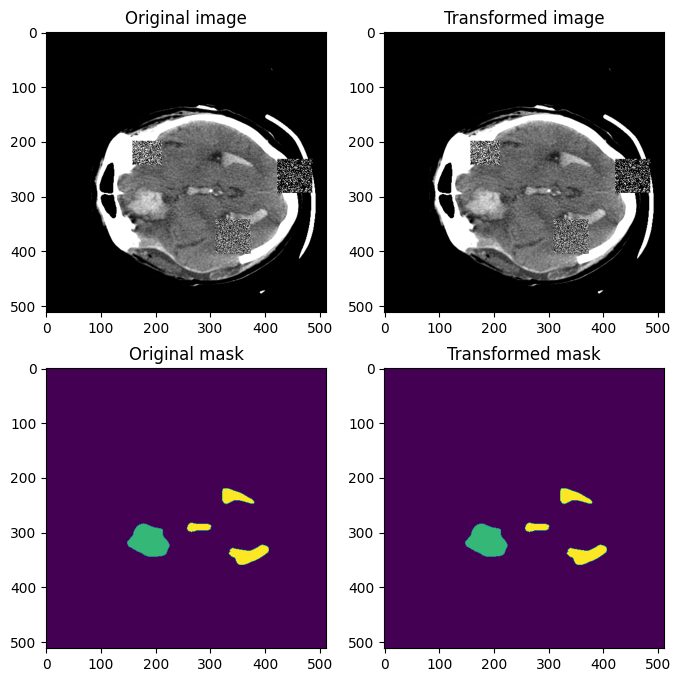

In [130]:
transform = transforms.RandCoarseShuffled(
    keys="image",
    holes=2,
    spatial_size=38,
    max_holes=4,
    max_spatial_size=64,
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

image mean: 159.78668212890625, image std: 51.98253631591797


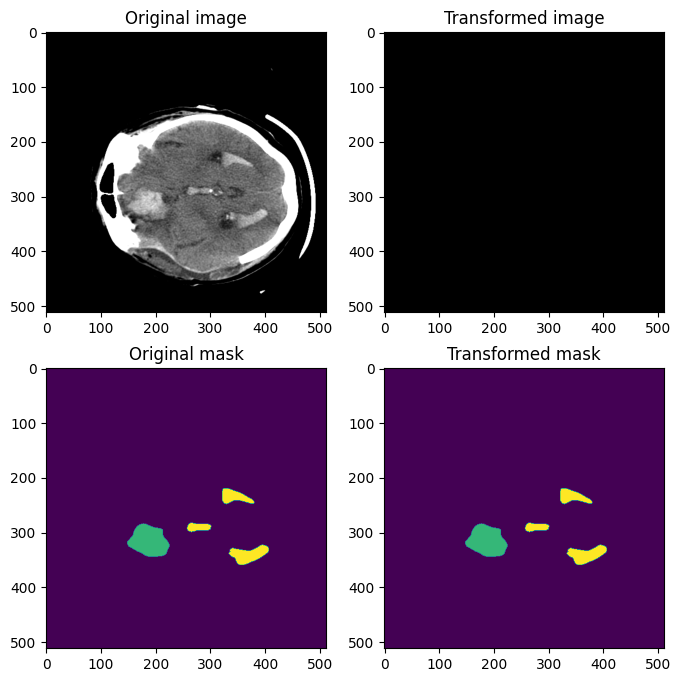

In [134]:
transform = transforms.HistogramNormalized(
    keys="image"
)
aug_data = transform(add_data)
print(f"image mean: {aug_data['image'].mean()}, image std: {aug_data['image'].std()}")
visualize(data, aug_data)

image shape: torch.Size([1, 507, 507, 186]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 507, 507, 186]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


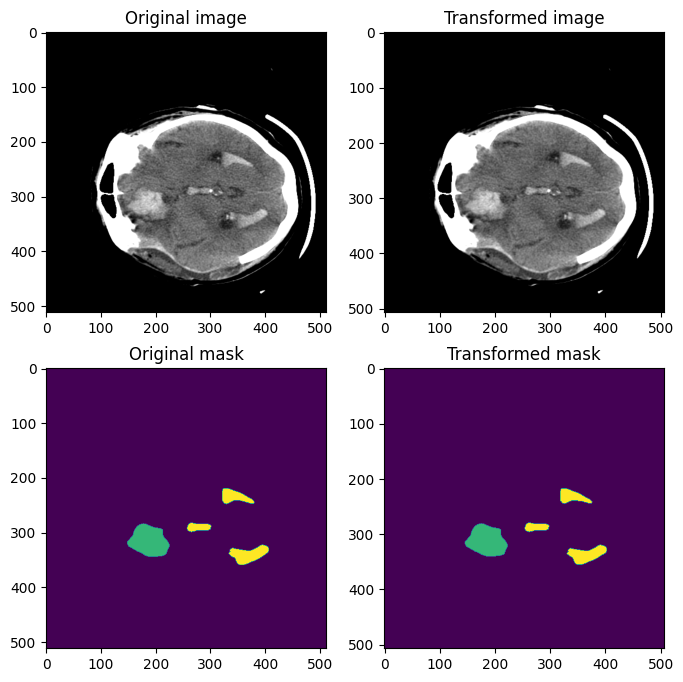

In [15]:
transform = transforms.Spacingd(
    keys=["image", "label"],
    pixdim=(0.5, 0.5, 1),
    mode=["bilinear", "nearest"]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data, ori_idx=20, aug_idx=100)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


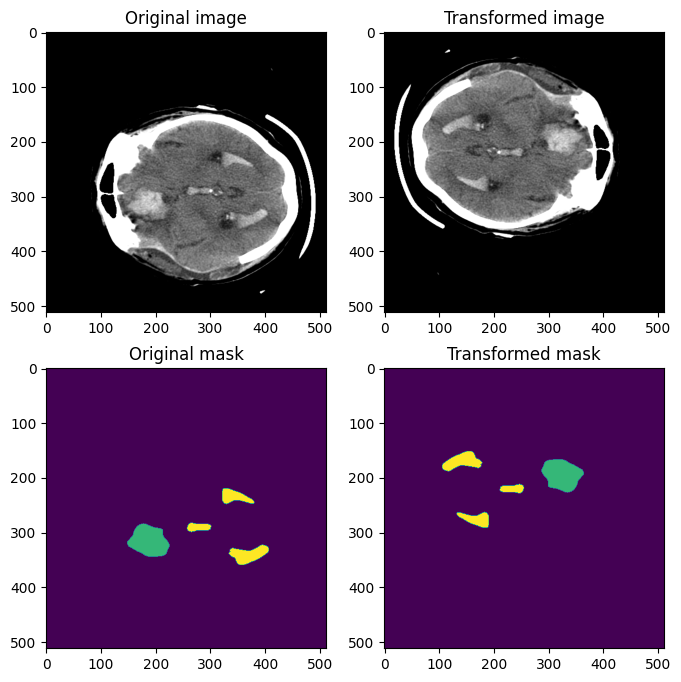

In [18]:
# (Left, Right), (Posterior, Anterior), (Inferior, Superior)
transform = transforms.Orientationd(
    keys=["image", "label"],
    axcodes="RAS"
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


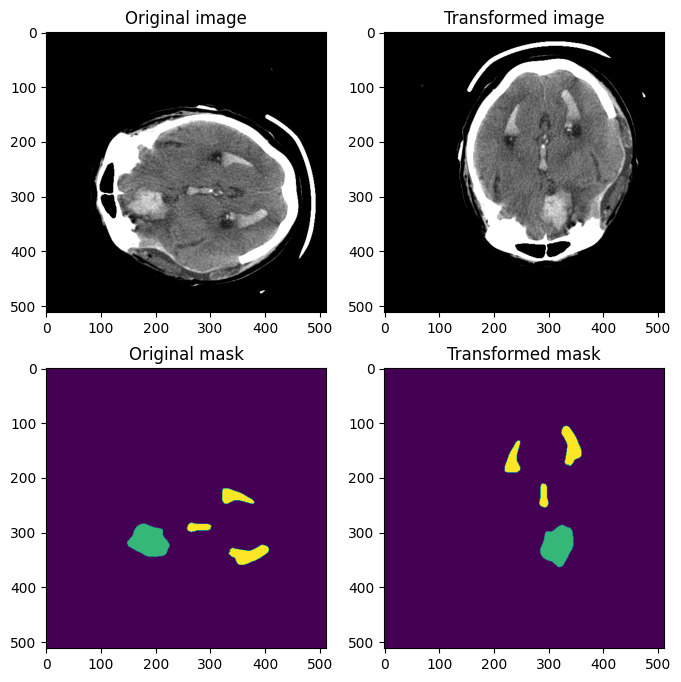

In [22]:
transform = transforms.Rotate90d(
    keys=["image", "label"],
    k=1,
    spatial_axes=(0, 1)
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


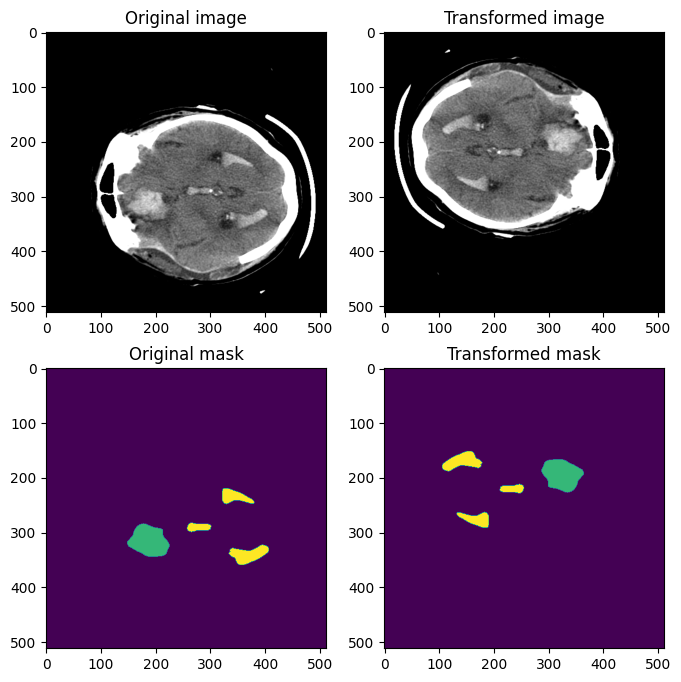

In [25]:
transform = transforms.RandRotate90d(
    keys=["image", "label"],
    prob=1,
    max_k=3,
    spatial_axes=(0, 1)
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

image shape: torch.Size([1, 468, 468, 76]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 468, 468, 76]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


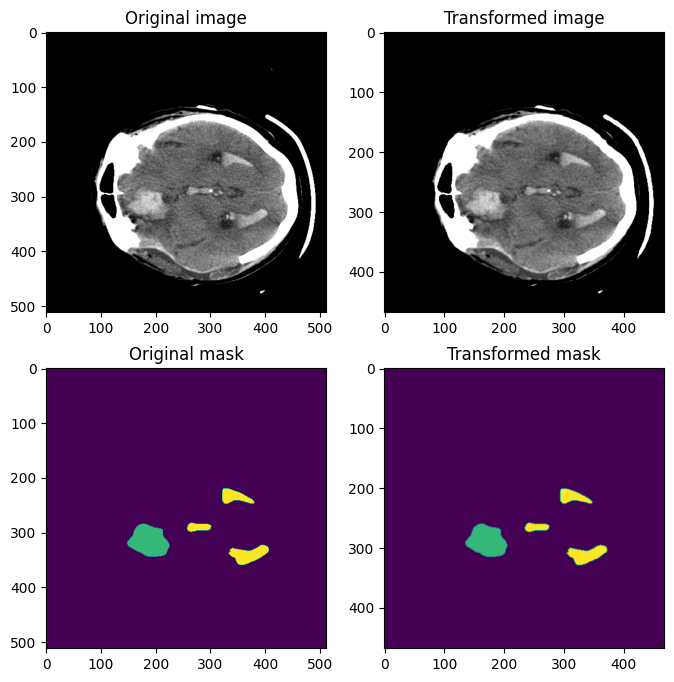

In [36]:
transform = transforms.Resized(
    keys=["image", "label"],
    spatial_size=(468, 468, 76)
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data, ori_idx=20, aug_idx=40)

image shape: torch.Size([1, 468, 468, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 468, 468, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


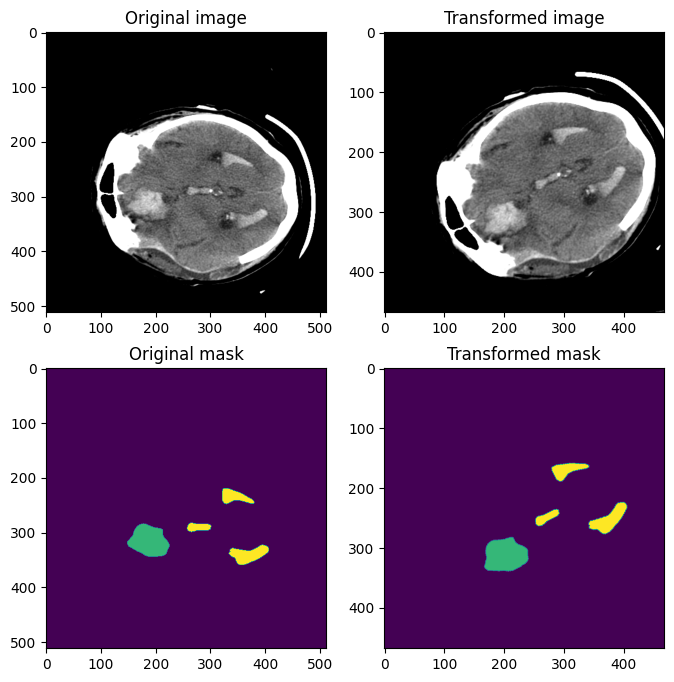

In [50]:
transform = transforms.RandAffined(
    keys=["image", "label"],
    spatial_size=(468, 468, 38),
    prob=1,
    rotate_range=(0, 0, np.pi/2),  # 绕z轴旋转90度
    translate_range=(10, -10, 0)   # 在xyz方向偏移
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

| 参数名               | 类型                   | 说明                                   |
| ----------------- | -------------------- | ------------------------------------ |
| `keys`            | list\[str]           | 应用变换的字典字段名（如 `["image", "label"]`）   |
| `prob`            | float                | 应用变换的概率                              |
| `sigma_range`     | tuple\[float, float] | 控制弹性扰动平滑程度的高斯核标准差                    |
| `magnitude_range` | tuple\[float, float] | 控制形变强度                               |
| `spatial_size`    | tuple\[int]          | 输出图像大小（如 `(96,96,96)`）；默认使用原始大小      |
| `rotate_range`    | float or tuple       | x/y/z轴旋转角度（单位弧度）                     |
| `translate_range` | float or tuple       | 位移范围（单位像素）                           |
| `scale_range`     | float or tuple       | 缩放比例变化范围                             |
| `mode`            | str or list          | 插值方法（图像为 bilinear，mask 用 nearest）    |
| `padding_mode`    | str                  | 边界填充方法：`zeros`、`border`、`reflection` |

image shape: torch.Size([1, 468, 468, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 468, 468, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


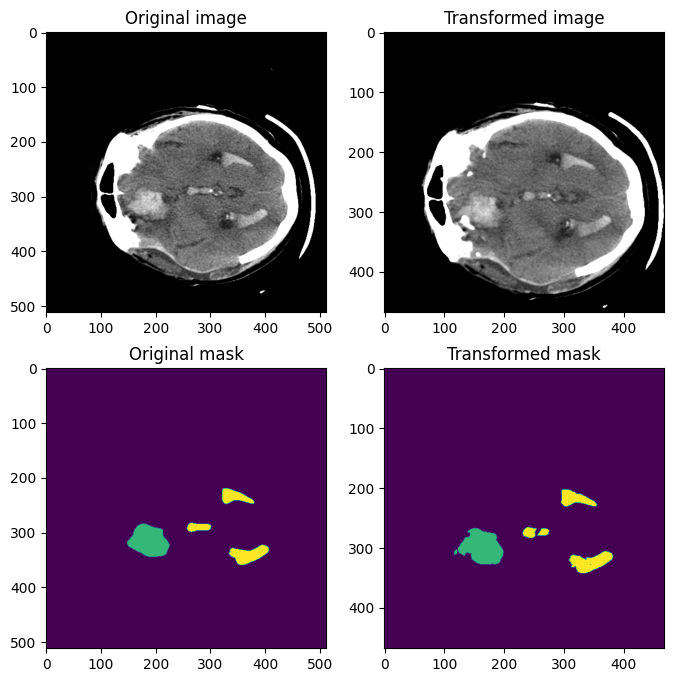

In [58]:
transform = transforms.Rand3DElasticd(
    keys=["image", "label"],
    prob=1,
    sigma_range=(4, 6),
    magnitude_range=(20, 50),
    # rotate_range=(0, 0, np.pi/2),
    translate_range=(10, -10, 0),
    mode=["bilinear", "nearest"],
    spatial_size=(468, 468, 38)
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


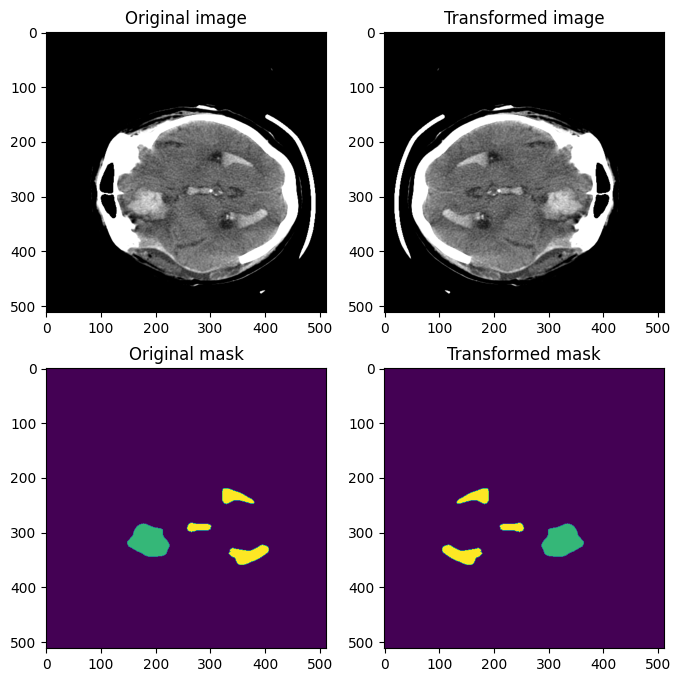

In [60]:
transform = transforms.RandFlipd(
    keys=["image", "label"],
    prob=1,
    spatial_axis=1
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


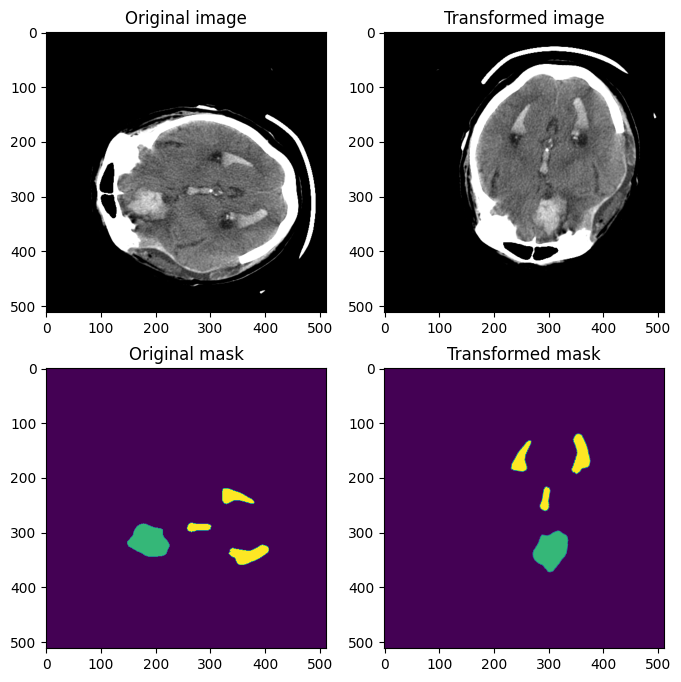

In [64]:
transform = transforms.RandRotated(
    keys=["image", "label"],
    range_z=np.pi/2,
    prob=1,
    keep_size=True
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


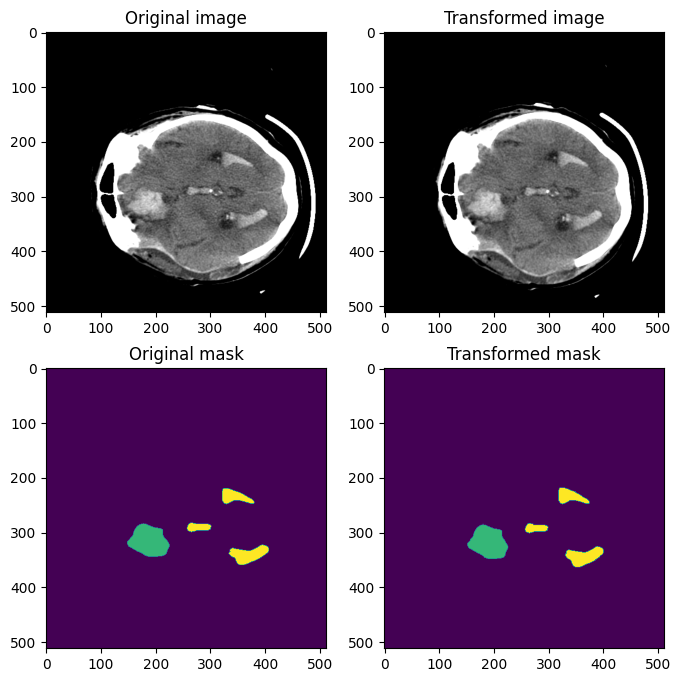

In [73]:
transform = transforms.RandZoomd(
    keys=["image", "label"],
    prob=1,
    min_zoom=(0.6, 0.6, 1),
    max_zoom=(1.4, 1.4, 1),
    keep_size=True,
    mode=["bilinear", "nearest"]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


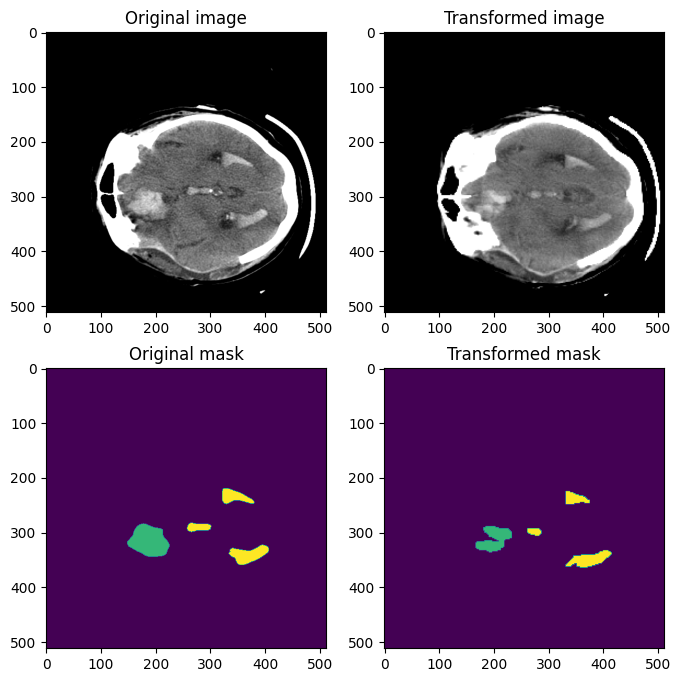

In [81]:
transform = transforms.RandGridDistortiond(
    keys=["image", "label"],
    num_cells=[256, 256, 4],
    prob=1,
    distort_limit=0.3,
    mode=["bilinear", "nearest"]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


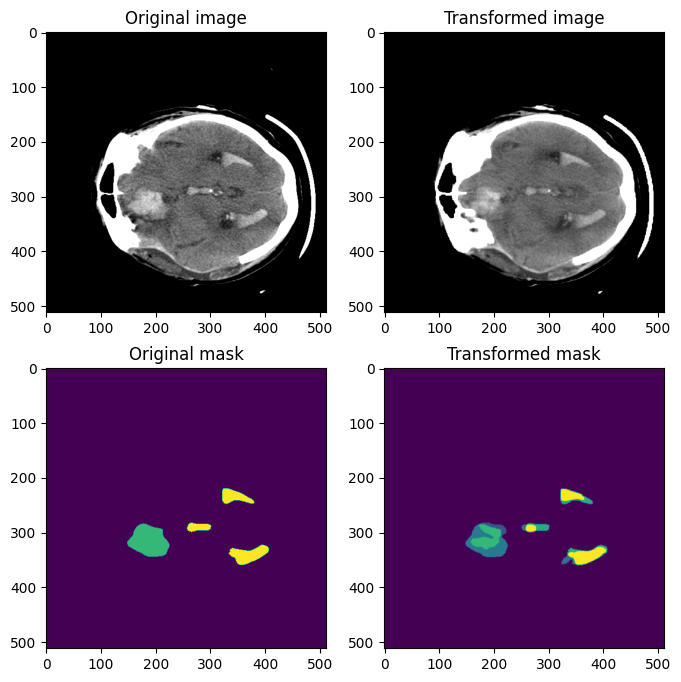

In [85]:
transform = transforms.RandSimulateLowResolutiond(
    keys=["image", "label"],
    prob=1,
    zoom_range=(1.0, 1.5),
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)